In [ ]:
---
skip_exec: true
---

# core

> The core package contains the `Chat` class central to this package.

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import os
import requests
import json
from datetime import datetime
from IPython.display import Markdown, display_markdown
from fastcore.basics import patch
from dotenv import load_dotenv

The following line loads the OpenRouter api key from the `.env` file which is hidden from you. To use this notebook, either create a `.env` file containing `OPENROUTER_API_KEY=your_api_key` or uncomment the `os.environ` assignment below and set it to your personal api key.

In [ ]:
load_dotenv("../.env")
# os.environ['OPENROUTER_API_KEY'] = <your OpenRouter api key>

True

In [ ]:
#| export
def show(string): return Markdown(string)

In [ ]:
#| export
class Chat():
    def __init__(self, model):
        self.model = model
        self.usage = []
        self.context = []
        self.date = None
        self.time = None
        self.history = []
        self.chatsdir = ''
        self.title = f"conversation-with-{self.model.split('/')[1].replace(':', '-')}"
        
    def __call__(self, prompt):
        self.context.append({"role": "user", "content": prompt})
        resp = requests.post(url="https://openrouter.ai/api/v1/chat/completions", 
                             headers={"Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}"},
                             json={"model": self.model,
                                   "messages": self.context})
        ans = resp.json()['choices'][0]['message']
        self.context.append(ans)
        self.usage.append(resp.json()['usage'])
        self.date = resp.json()['created']
        self.history.append(resp.json())
        self.chatsdir = f"chats/{self.history[-1]['model']}/"
        return self._show(ans['content'])
        
    def _show(self, string): return Markdown(string)
        
    def usage_summary(self):
        intok = [u['prompt_tokens'] for u in self.usage]
        outok = [u['completion_tokens'] for u in self.usage]
        totok = [u['total_tokens'] for u in self.usage]
        print(f"Input tokens: {sum(intok)}\nOutput tokens: {sum(outok)}\nTotal tokens: {sum(totok)}")
        
    def forget_last(self):
        self.context = self.context[:-1]
        return self.context

In [ ]:
#| export
@patch
def save_conversation(self:Chat, generate_title=True):
    conv = json.dumps(self.context, ensure_ascii=False, indent=2)
    self.time = datetime.fromtimestamp(self.date).strftime('%Y%m%d-%H%M%S')
    os.makedirs(self.chatsdir, exist_ok=True)
    if generate_title:
        self.context.append({"role": "user", "content": "Generate an all lower case title for our conversation connecting the words with hyphens (-) instead of spaces. Output nothing but the title. Five words max!"})
        resp = requests.post(url="https://openrouter.ai/api/v1/chat/completions", 
                             headers={"Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}"},
                             json={"model": self.model,
                                   "messages": self.context})
        self.usage.append(resp.json()['usage'])
        self.title = resp.json()['choices'][0]['message']['content'].strip()
        self.forget_last()
    
    file_path = self.chatsdir + self.time + "-" + self.title + ".txt"
    with open(file_path, 'w') as f:
        f.write(conv)
    return "Saving complete!"

In [ ]:
model = "google/gemini-2.0-pro-exp-02-05:free"
chat = Chat(model)

In [ ]:
chat("Give me the canonical SMILES string of ibuprofen. Output only the SMILES string and nothing else.")

CC(C)Cc1ccc(C(C)C(=O)O)cc1


In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

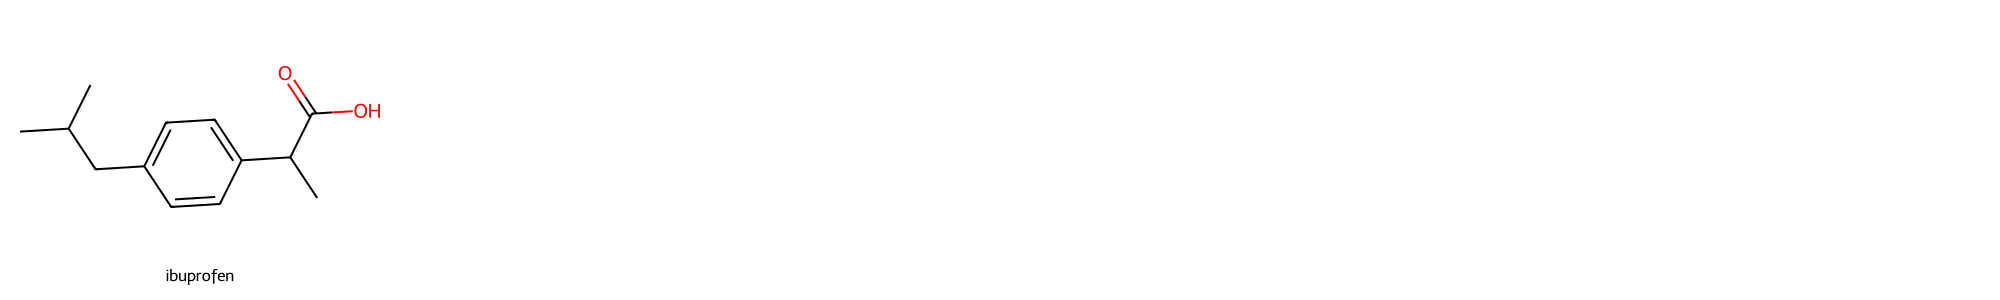

In [ ]:
names = ["ibuprofen"]
smiles = [chat.context[-1]['content']]

Draw.MolsToGridImage(mols=[Chem.MolFromSmiles(x) for x in smiles], 
                     molsPerRow=5, subImgSize=(400,300), legends=names)

In [ ]:
chat.save_conversation(generate_title=False)

'Saving complete!'

In [ ]:
chat.save_conversation()

'Saving complete!'

In [ ]:
chat.title

'ibuprofen-smiles-string-generation'

In [ ]:
chat.usage

[{'prompt_tokens': 21, 'completion_tokens': 20, 'total_tokens': 41},
 {'prompt_tokens': 73, 'completion_tokens': 9, 'total_tokens': 82}]

In [ ]:
chat.usage_summary()

Input tokens: 94
Output tokens: 29
Total tokens: 123


In [ ]:
chat.date

1740427285

In [ ]:
#| export
@patch
def print_conversation(self:Chat, user="Me"):
    assistant = self.model.split("/")[1].split("-")[0].capitalize()
    title = " ".join(self.title.split('-')).capitalize()
    display_markdown(self._show(f"**{title}**"))
    for i in self.context:
        if i['role'] == 'user':
            display_markdown(self._show(f"**{user}**: {i['content']}"))
        elif i['role'] == 'assistant':
            display_markdown(self._show(f"**{assistant}**: {i['content']}"))

In [ ]:
chat.print_conversation()

**Ibuprofen smiles string generation**

**Me**: Give me the canonical SMILES string of ibuprofen. Output only the SMILES string and nothing else.

**Gemini**: CC(C)Cc1ccc(C(C)C(=O)O)cc1


In [ ]:
#| export
def print_conversation(conversation, user="User", assistant="Assistant"):
    for i in conversation:
        if i['role'] == 'user':
            display_markdown(show(f"**{user}**: {i['content']}"))
        elif i['role'] == 'assistant':
            display_markdown(show(f"**{assistant}**: {i['content']}"))

In [ ]:
file_path = chat.chatsdir + chat.time + "-" + chat.title + ".txt"
assistant = file_path.split("/")[-2].split("-")[0].capitalize()

with open(file_path, 'r') as f:
    conv = f.read()
    
print_conversation(json.loads(conv), user="Me", assistant=assistant)

**Me**: Give me the canonical SMILES string of ibuprofen. Output only the SMILES string and nothing else.

**Gemini**: CC(C)Cc1ccc(C(C)C(=O)O)cc1


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()